# Imports

In [23]:
from imports import *
from hyperparameters import Hyperparameters
from trial_function import TrialFunction
from metropolis_sampler import MetropolisSampler

# Training procedure

In [24]:
def train(
    trialFunction: TrialFunction,
    hyperparameters: Hyperparameters
):
    """Trains trial function"""
    initialTime = time.time()
    timeHistory =  np.full(hyperparameters.numberOfTrainingSteps, np.nan)
    lossHistory = {
        'total loss' : np.full(hyperparameters.numberOfTrainingSteps, np.nan),
        'total squered residual' : np.full(hyperparameters.numberOfTrainingSteps, np.nan),
        'total normalisation error' : np.full(hyperparameters.numberOfTrainingSteps, np.nan),
        'total orthogonalisation error' : np.full(hyperparameters.numberOfTrainingSteps, np.nan)
    }
    eHistory = [None] * hyperparameters.numberOfTrainingSteps
    optimizer = torch.optim.AdamW(
        params=list(trialFunction.parameters()),
        lr=hyperparameters.initialLearningRate,
        weight_decay=hyperparameters.weightDecay,
    )
    lossFunction = nn.L1Loss()
    print(
        "Step, Time [s], Residual-term, Normalization-term,"
        + " Orthogonalization-term, Sorted energies"
    )
    for stepNumber in range(hyperparameters.numberOfTrainingSteps):
        if stepNumber == 0:
            sampler = MetropolisSampler(hyperparameters)
        else:
            for i in range(10):
                sampler.updateSampleBasOnDistrDens(trialFunction.weightFunction)
        # Loss function
        r = trialFunction.totalSqueredResidual(sampler.sample)
        a = trialFunction.totalNormalisationError(sampler.sample)
        b = trialFunction.totalOrthogonalisationError(sampler.sample)
        e = trialFunction.spectrum(sampler.sample)
        loss = lossFunction(
            hyperparameters.residualTermWeight * r
            + hyperparameters.normalisationTermWeight * a
            + hyperparameters.orthogonalisationTermWeight * b
            + hyperparameters.energyTermWeight * torch.sum(e),
            torch.tensor(0.0).to(hyperparameters.device),
        )
        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # Save some history
        timeHistory[stepNumber] = time.time() - initialTime
        if np.isnan(loss.item()):
            torch.save(trialFunc.state_dict(), trialFunc.PATH)
            print("LOSS IS NAN (model has been saved)")
            sys.exit(1)
        lossHistory['total loss'][stepNumber] = loss.item()
        lossHistory['total squered residual'][stepNumber] = r.cpu().detach().numpy()
        lossHistory['total normalisation error'][stepNumber] = a.cpu().detach().numpy()
        lossHistory['total orthogonalisation error'][stepNumber] = b.cpu().detach().numpy()
        eHistory[stepNumber] = e.cpu().detach().numpy()
        # Release some memory
        if torch.cuda.is_available():
            torch.cuda.empty_cache()
        # Print the state of the model
        if stepNumber % 500 == 0:
            print(
                f"{stepNumber},"
                + f" {timeHistory[stepNumber]:.2f},"
                + f" {r.cpu().detach().numpy():.4e},"
                + f" {a.cpu().detach().numpy():.4e}," 
                + f" {b.cpu().detach().numpy():.4e},"
                + f" {np.sort(eHistory[stepNumber])}"
            )
    timeHistoryDF = pd.DataFrame(data={'time [s]' : timeHistory})
    lossHistoryDF = pd.DataFrame(data=lossHistory)
    eHistoryDF = pd.DataFrame(data=eHistory)
    return timeHistoryDF, lossHistoryDF, eHistoryDF     

# 3D

## Hyperparameters

In [28]:
hyperparameters_3d = Hyperparameters("../hyperparameters/hyperparameters_3d.csv")
pd.read_csv("../hyperparameters/hyperparameters_3d.csv")

,name,value
0,activation function,sin
1,amplitude function,gaussian
2,hidden layer size,100
3,coordinate space dimension,3
4,number of states,5
5,batch size,8192
6,initial learning rate,0.001
7,weight decay,0.001
8,residual term weight,1.0
9,normalisation term weight,1.0


## Tests

In [4]:
numberOfTests = 1
trialFunction_3D = [None] * numberOfTests
timeHistory = [None] * numberOfTests
lossHistory = [None] * numberOfTests
eHistory = [None] * numberOfTests

for testNumber in range(numberOfTests):
    print(f"Test {testNumber}")
    trialFunction_3D[testNumber] = TrialFunction(
        hyperparameters_3d,
        f"3d_{testNumber}"
    )
    timeHistory[testNumber], lossHistory[testNumber], eHistory[testNumber] = train(
        trialFunction_3D[testNumber],
        hyperparameters_3d
    )
    torch.save(
        trialFunction_3D[testNumber].state_dict(), 
        trialFunction_3D[testNumber].PATH
    )
    timeHistory[testNumber].to_csv(f"../loss/time_3d_{testNumber}.csv")
    lossHistory[testNumber].to_csv(f"../loss/loss_3d_{testNumber}.csv")
    eHistory[testNumber].to_csv(f"../loss/e_3d_{testNumber}.csv")

Test 0
Step, Time [s], Residual-term, Normalization-term, Orthogonalization-term, Sorted energies
0, 1.10, 3.7781e+03, 7.7583e-04, 3.5622e-02, [22.665033 23.725796 24.274424 25.719389 30.714167]
1, 1.38, 3.2274e+03, 1.0655e-03, 2.9038e-02, [21.2731   23.421608 25.635286 27.278755 29.071598]
2, 1.65, 2.3847e+03, 4.4194e-04, 5.0705e-02, [19.851828 21.36818  22.135445 23.421078 23.503155]
3, 1.91, 1.7736e+03, 6.3942e-04, 5.5007e-02, [18.657154 19.182983 19.872173 20.012062 20.138273]
4, 2.19, 1.4084e+03, 1.1628e-03, 8.2354e-02, [16.290377 16.671686 16.831053 17.716764 18.471584]
5, 2.49, 1.1313e+03, 3.7714e-03, 1.6813e-01, [13.73542  14.325831 14.560792 16.115211 16.37404 ]
6, 2.75, 9.7005e+02, 3.4165e-03, 2.3187e-01, [11.353429 12.925227 13.053502 14.712702 15.247798]
7, 3.02, 8.3718e+02, 3.1411e-03, 2.6910e-01, [10.493887 11.727912 12.333442 13.549206 14.529436]
8, 3.28, 7.4653e+02, 3.1746e-03, 2.9360e-01, [10.180507 10.962989 12.134721 12.754452 13.320408]
9, 3.54, 6.6576e+02, 5.8466e-

KeyboardInterrupt: 

TypeError: 'NoneType' object is not callable

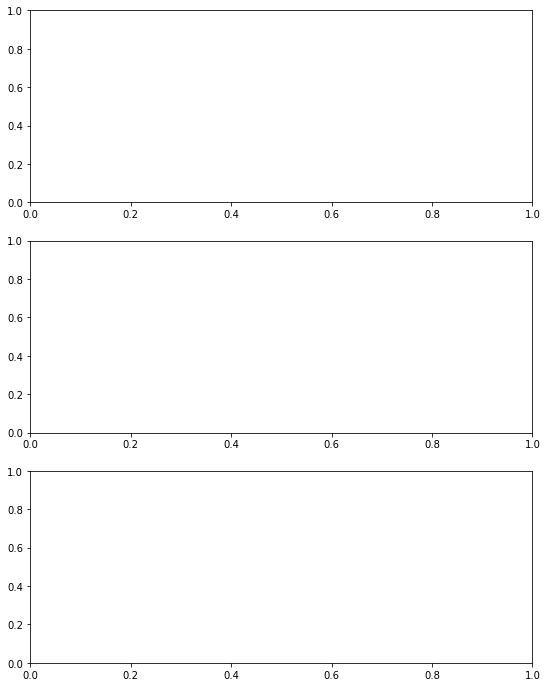

In [29]:
fig, axes = plt.subplots(
    3,numberOfTests,
    figsize=(9*numberOfTests,12),
    squeeze=False
)

for j in range(numberOfTests):
    for axNumber, ax in enumerate(axes[:,j]):
        grid = torch.zeros(
           (1000,hyperparameters_3d.coordinateSpaceDim),
            device=hyperparameters_3d.device
        )
        grid[:,axNumber] = torch.linspace(-3,3,1000,device=hyperparameters_3d.device)
        for i in range(5):
            ax.plot(
                grid[:,axNumber].cpu().detach().numpy(), 
                (
                    trialFunction_3D[j](grid)[:,i].cpu().detach().numpy()**2
                    / trialFunction_3D[j].norm(grid)[i].cpu().detach().numpy()
                ),
                label=f'E={trialFunction_3D[j].spectrum(grid)[i]:.4f}'
            )
        ax.set_title(f"Axis {axNumber+1}")
        ax.legend()
        ax.set_xlim(-3,3)
        ax.set_ylim(0,None)
        ax.grid()
    plt.xlabel(f'Test {j+1}', fontsize=16)

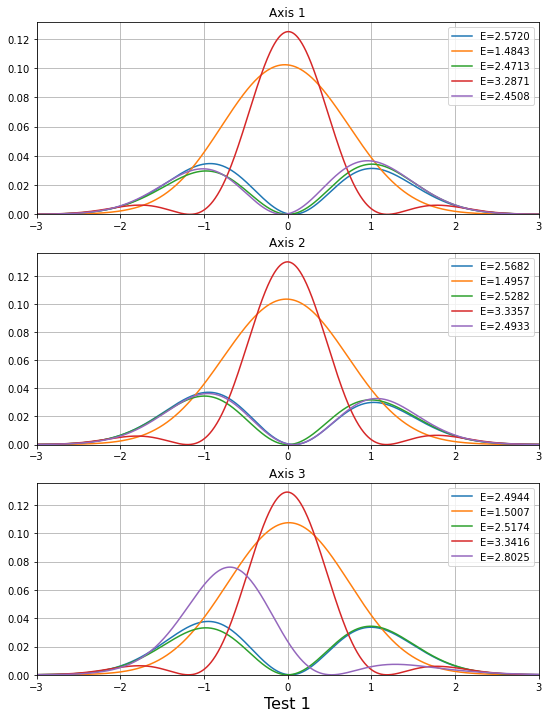

In [31]:
numberOfTests = 1
trialFunction_3D = [None] * numberOfTests

trialFunction_3D[0] = TrialFunction(hyperparameters_3d, "3d_0")
trialFunction_3D[0].load_state_dict(torch.load(trialFunction_3D[0].PATH))
trialFunction_3D[0].eval()

fig, axes = plt.subplots(
    3,numberOfTests,
    figsize=(9*numberOfTests,12),
    squeeze=False
)

for j in range(numberOfTests):
    for axNumber, ax in enumerate(axes[:,j]):
        grid = torch.zeros(
           (1000,hyperparameters_3d.coordinateSpaceDim),
            device=hyperparameters_3d.device
        )
        grid[:,axNumber] = torch.linspace(-3,3,1000,device=hyperparameters_3d.device)
        for i in range(5):
            ax.plot(
                grid[:,axNumber].cpu().detach().numpy(), 
                (
                    trialFunction_3D[j](grid)[:,i].cpu().detach().numpy()**2
                    / trialFunction_3D[j].norm(grid)[i].cpu().detach().numpy()
                ),
                label=f'E={trialFunction_3D[j].spectrum(grid)[i]:.4f}'
            )
        ax.set_title(f"Axis {axNumber+1}")
        ax.legend()
        ax.set_xlim(-3,3)
        ax.set_ylim(0,None)
        ax.grid()
    plt.xlabel(f'Test {j+1}', fontsize=16)

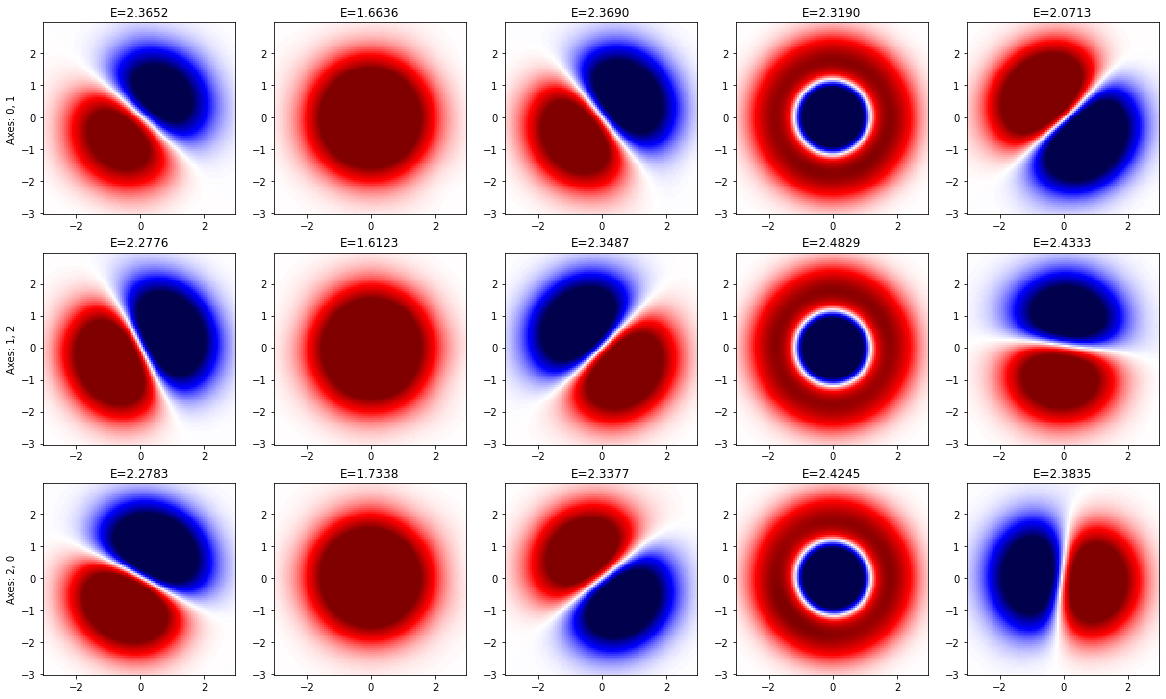

In [34]:
fig, axes = plt.subplots(
    3,5,
    figsize=(20,12),
    squeeze=False
)
j = 0
for axNumber in range(3):
    grid = torch.zeros(
        (10000,3),
        device="cuda"
    )
    for ix in range(100):
        for iy in range(100):
            grid[ix*100+iy,axNumber%3] = -3 + 6 * ix / 100
            grid[ix*100+iy,(axNumber+1)%3] = -3 + 6 * iy / 100
    for i in range(5):
        axes[axNumber,i].pcolormesh(
            -3 + 6 * np.arange(100) / 100,
            -3 + 6 * np.arange(100) / 100, 
            trialFunction_3D[j](grid)[:,i].cpu().detach().numpy().reshape(100,100),
            shading='nearest',
            cmap='seismic',
            vmin=-0.1, vmax=0.1
        )
        axes[axNumber,i].set_title(fr'E={trialFunction_3D[j].spectrum(grid)[i]:.4f}')
    axes[axNumber,0].set_ylabel(f"Axes: {axNumber%3}, {(axNumber+1)%3}")
    # ax.set_title()
    # axes.legend()
    # ax.set_xlim(-3,3)
    # ax.set_ylim(0,None)
    # axes.grid()
# fig.adjust_subplots(hspace=0.2)
# fig.a

In [3]:
numberOfTests = 1
timeHistory_1 = pd.read_csv("../loss/time_3d_05Oct2023_14:55:52.csv")
lossHistory_1 = pd.read_csv("../loss/loss_3d_05Oct2023_14:55:52.csv")
eHistory_1 = pd.read_csv("../loss/e_3d_05Oct2023_14:55:52.csv")

Text(0.5, 0, 'Iteration number')

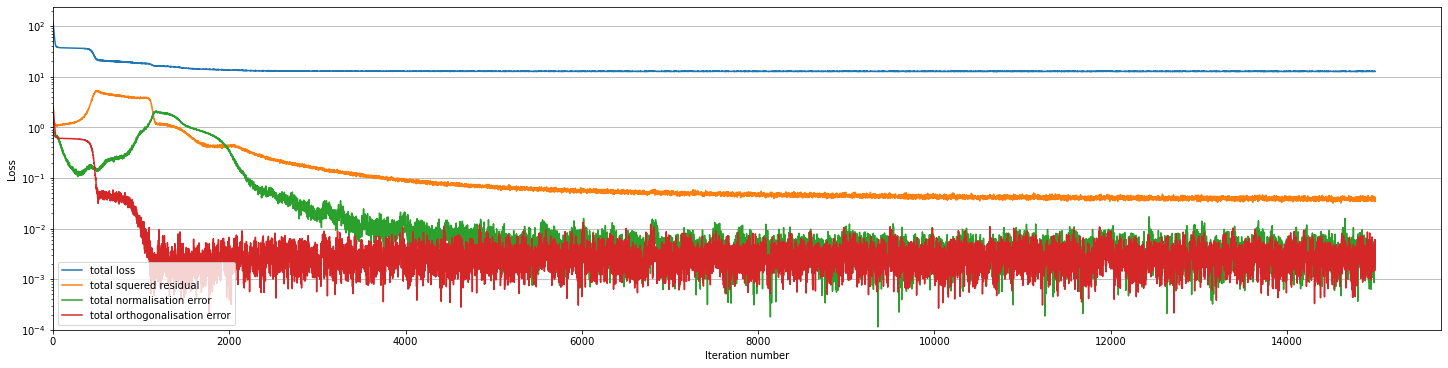

In [4]:
# fig, axes = plt.subplots(numberOfTests, 1, figsize=(10,10), layout='constrained')

# for testNumber, ax in enumerate(axes[:1]):
#     lossHistory[testNumber].plot(ax=ax)
#     ax.set_yscale('log')
#     ax.grid(axis='y')
#     ax.set_ylim(1e-4,None)
#     ax.set_xlim(0,None)
#     ax.set_ylabel('Loss')
#     ax.set_title(f"Test {testNumber}")
# plt.xlabel('Iteration number')

# for testNumber, ax in enumerate(axes[:1]):
    # lossHistory[testNumber].plot(ax=ax)
fig, ax = plt.subplots(1, 1, figsize=(20,5), layout='constrained')
lossHistory_1[[
    'total loss', 
    'total squered residual', 
    'total normalisation error',
    'total orthogonalisation error'
]].plot(ax=ax)
ax.set_yscale('log')
ax.grid(axis='y')
ax.set_ylim(1e-4,None)
ax.set_xlim(0,None)
ax.set_ylabel('Loss')
plt.xlabel('Iteration number')


Text(0.5, 0, 'Iteration number')

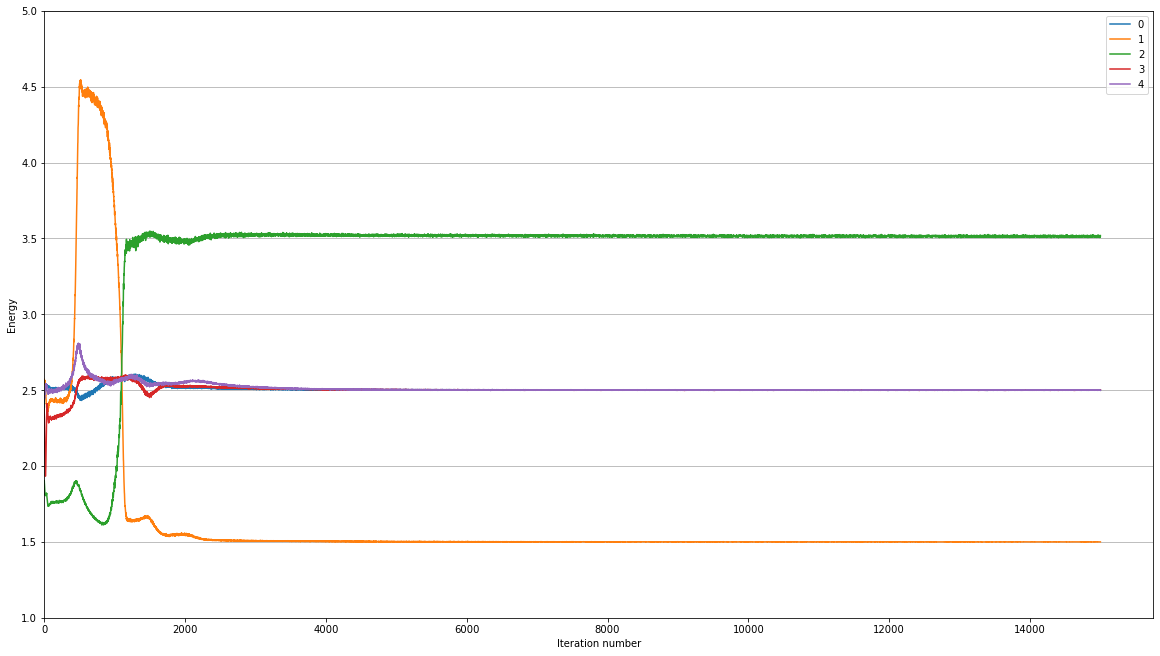

In [13]:
fig, ax = plt.subplots(1, 1, figsize=(16,9), layout='constrained')
eHistory_1[[
    '0', 
    '1', 
    '2',
    '3',
    '4'
]].plot(ax=ax)
# ax.set_yscale('log')
ax.grid(axis='y')
ax.set_ylim(1,5)
ax.set_xlim(0,None)
ax.set_ylabel('Energy')
plt.xlabel('Iteration number')

In [ ]:
fig, axes = plt.subplots(numberOfTests, 1, figsize=(10,10), layout='constrained')

for testNumber, ax in enumerate(axes[:1]):
    eHistory[testNumber].plot(ax=ax)
    # ax.set_yscale('log')
    ax.grid(axis='y')
    ax.set_ylim(1,5)
    ax.set_xlim(0,None)
    ax.set_ylabel('Loss')
    ax.set_title(f"Test {testNumber}")
plt.xlabel('Iteration number')


In [ ]:
model = TrialFunction(hyperparameters_3d, "3d_0")
model.load_state_dict(torch.load(model.PATH))
model.eval()

In [ ]:
trialFunction_3D[0].totalNormalisationError(grid)

In [ ]:
trialFunction_3D[0].spectrum(grid)